In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
import ast as ast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Normalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
filename = '../../Preprocess/GadgetX-NewMDCLUSTER-1/progenitor-pair/128 snapshots/training_data.csv'
os.path.exists(filename)

True

In [3]:
training_data = pd.read_csv('../../Preprocess/GadgetX-NewMDCLUSTER-1/progenitor-pair/128 snapshots/training_data.csv')
training_data.head()

,hostHalo,numSubStruct,Mvir,npart,Xc,Yc,Zc,VXc,VYc,VZc,...,progenitor_Phi0,progenitor_cNFW,progenitor_ID,progenitor_numProgenitors,progenitor_ProgenitorsID,progenitor_redshift,progenitor_snapshot,rel_location,rel_velocity,Is_Progenitor
0,0,1,1.194320e+12,2388,491500.296659,518076.353644,488717.205503,129.63,-627.76,970.22,...,302568.0,3.06591,88000000000318,1,[87000000000360],1.425,88,3396.093394,230.490771,0
1,0,0,2.536440e+11,41,504146.830241,471645.736694,510191.893578,118.86,297.52,-298.17,...,9261.8,13.45310,109000000019986,1,[108000000020513],0.523,109,4658.358144,331.913253,0
2,0,0,4.763950e+10,53,502569.429080,497138.503194,502457.616727,-1225.27,615.67,-84.02,...,196636.0,7.88160,106000000000620,1,[105000000000668],0.628,106,3408.032744,1371.386905,0
3,0,0,6.847900e+10,80,511772.554295,504550.229101,501548.588276,-1274.80,-162.87,-97.98,...,137324.0,17.13470,93000000001535,1,[92000000001495],1.170,93,4780.720871,669.333124,0
4,0,0,5.191940e+10,58,495223.954320,486824.937993,489803.996351,395.66,28.44,604.51,...,16714.9,8.32033,126000000008659,1,[125000000007894],0.045,126,162.209651,8.278315,1


In [8]:
training_data['ProgenitorsID'] = training_data['ProgenitorsID'].apply(ast.literal_eval)

In [9]:
features = ['rel_location', 'rel_velocity', 'Is_Progenitor', 'Mvir']

#progenitor_features = [f'progenitor_{feature}' for feature in features if feature != 'Is_Progenitor']
progenitor_features = ['progenitor_Mvir']

# Select only the defined features from the training data
training_data = training_data[features + progenitor_features]

training_data.head()

,rel_location,rel_velocity,Is_Progenitor,Mvir,progenitor_Mvir
0,3396.093394,230.490771,0,1.194320e+12,1.492420e+12
1,4658.358144,331.913253,0,2.536440e+11,2.092710e+10
2,3408.032744,1371.386905,0,4.763950e+10,9.008880e+11
3,4780.720871,669.333124,0,6.847900e+10,3.016390e+11
4,162.209651,8.278315,1,5.191940e+10,4.867230e+10


In [10]:
# Separate features and target variable
X = training_data.drop('Is_Progenitor', axis=1)
y = training_data['Is_Progenitor']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Defining the model
model = Sequential()
model.add(Dense(28,input_shape=(4,), activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(18, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
#model.add(Dense(10, activation='relu'))
#model.add(Dense(6, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summarising  the model
model.build((1,18))
model.summary()

# Preparing the callbacks to save the best model and prevent overfitting.
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 28)                140       
                                                                 
 dense_1 (Dense)             (None, 18)                522       
                                                                 
 dense_2 (Dense)             (None, 10)                190       
                                                                 
 dense_3 (Dense)             (None, 2)                 22        
                                                                 
 dense_4 (Dense)             (None, 1)                 3         
                                                                 
Total params: 877
Trainable params: 877
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Fitting the model to the data
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=100, 
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/100
18270/18278 [============================>.] - ETA: 0s - loss: 0.0417 - accuracy: 0.9876
Epoch 1: val_accuracy improved from -inf to 0.98848, saving model to best_model.h5
18278/18278 [==============================] - 60s 3ms/step - loss: 0.0417 - accuracy: 0.9876 - val_loss: 0.0352 - val_accuracy: 0.9885
Epoch 2/100
18275/18278 [============================>.] - ETA: 0s - loss: 0.0343 - accuracy: 0.9886
Epoch 2: val_accuracy improved from 0.98848 to 0.98905, saving model to best_model.h5
18278/18278 [==============================] - 60s 3ms/step - loss: 0.0342 - accuracy: 0.9886 - val_loss: 0.0328 - val_accuracy: 0.9891
Epoch 3/100
18268/18278 [============================>.] - ETA: 0s - loss: 0.0338 - accuracy: 0.9887
Epoch 3: val_accuracy did not improve from 0.98905
18278/18278 [==============================] - 60s 3ms/step - loss: 0.0338 - accuracy: 0.9887 - val_loss: 0.0328 - val_accuracy: 0.9890
Epoch 4/100
18271/18278 [============================>.] - ETA: 0s - 

In [9]:
def plots(history):
    # Set a layout
    plt.figure(figsize=(10,10))

    # Plotting accuracy
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], 'o-', label='train accuracy')
    plt.plot(history.history['val_accuracy'], 'o-', label = 'validation accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.legend(loc='lower right')

    # Plotting loss
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], 'o-', label='train loss')
    plt.plot(history.history['val_loss'], 'o-', label='validation loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


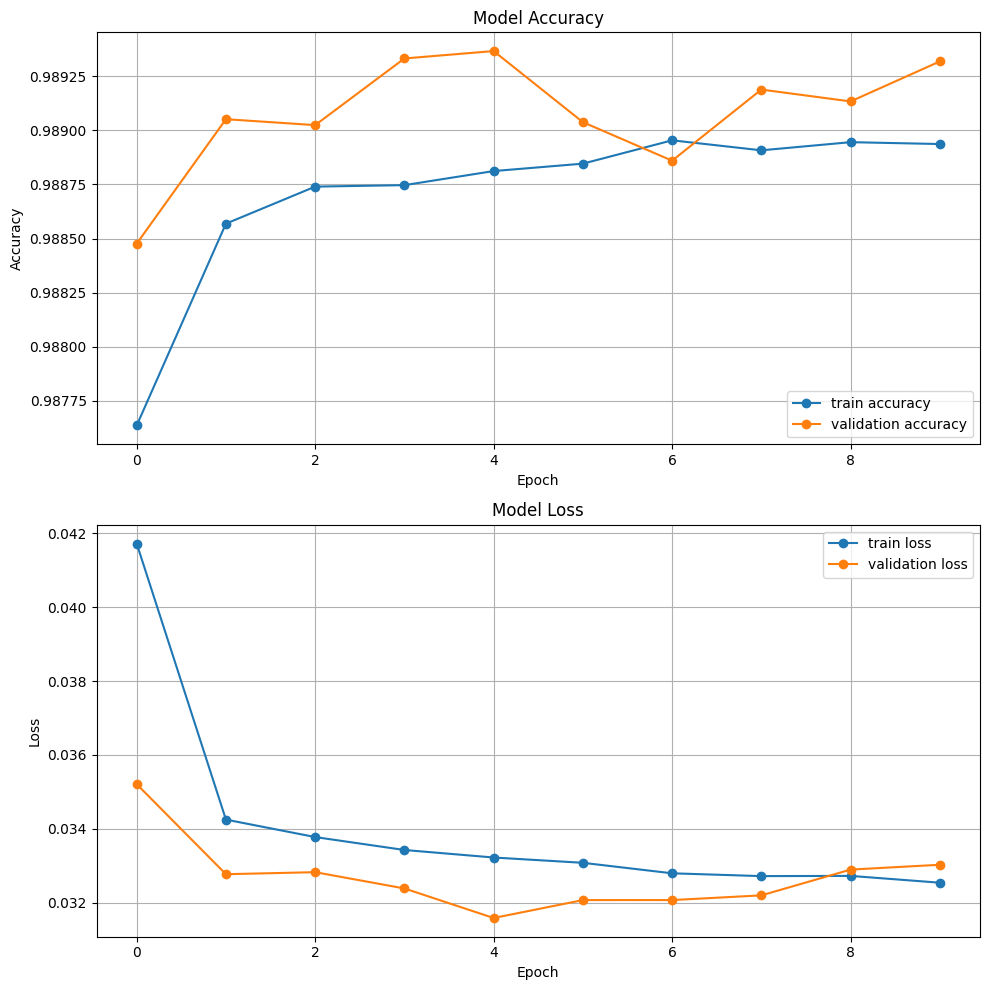

In [10]:
plots(history)

---

# Functions

In [5]:
import warnings
warnings.filterwarnings('ignore')

def create_merger_tree(halo, model, scaler, snapshot_dict, threshold=0.5, cache=None):
    if cache is None:
        cache = {}
    
    merger_tree = [halo]
    
    features = ['rel_location', 'rel_velocity', 'Mvir']
    progenitor_features = ['progenitor_Mvir']
    previous_snapshot = halo['snapshot'] - 1
    
    # Check if previous halos have been cached
    if previous_snapshot not in snapshot_dict:
        return merger_tree
    
    previous_halos = snapshot_dict[previous_snapshot]

    feature_vectors = []
    halo_pairs = []
    
    for _, previous_halo in previous_halos.iterrows():
        # Create the feature vector for the current pair of halos
        pair = pd.concat([halo, previous_halo.rename(lambda x: f'progenitor_{x}')])

        # calculate relative location and velocity
        rel_location = sum((pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2 for dim, dim_c in zip(['X', 'Y', 'Z'], ['Xc', 'Yc', 'Zc']))
        rel_velocity = sum((pair[dim_c] - pair[f'progenitor_{dim_c}']) ** 2 for dim, dim_c in zip(['VX', 'VY', 'VZ'], ['VXc', 'VYc', 'VZc']))
        
        pair['rel_location'] = np.sqrt(rel_location)
        pair['rel_velocity'] = np.sqrt(rel_velocity)

        feature_vector = pair[features + progenitor_features]
        feature_vectors.append(scaler.transform(feature_vector.values.reshape(1, -1)))
        halo_pairs.append(previous_halo)
    
    # Batch predict
    pred_probs = model.predict(np.vstack(feature_vectors), verbose=0)
    predictions = (pred_probs > threshold).astype(int)
    
    for pred, previous_halo in zip(predictions, halo_pairs):
        if pred == 1:
            merger_tree.append(previous_halo)
            # Check cache before making a recursive call
            if previous_halo.name not in cache:
                cache[previous_halo.name] = create_merger_tree(previous_halo, model, scaler, snapshot_dict, threshold, cache)
            merger_tree += cache[previous_halo.name]
                
    return merger_tree


def track_halo_history_predicted(halo, model, scaler, all_data):
    snapshot_dict = {snap: df for snap, df in all_data.groupby('snapshot')}
    history = create_merger_tree(halo, model, scaler, snapshot_dict)
    return pd.DataFrame(history)

def track_halo_history_real(halo_id, snapshot, df):
    halo = df[(df['ID'] == halo_id) & (df['snapshot'] == snapshot)]
    if len(halo) == 0:
        return pd.DataFrame()
    progenitors = halo.iloc[0]['ProgenitorsID']
    history = halo
    if progenitors:
        for progenitor in progenitors:
            if progenitor == -1:  # Ignore the progenitor if its ID is -1
                continue
            progenitor_history = track_halo_history_real(progenitor, snapshot - 1, df)
            history = pd.concat([history, progenitor_history])
    return history


def plot_halo_history(halo_id, real_halo_history, predicted_halo_history, title):
    fig, ax1 = plt.subplots(figsize=(12, 8))

    id_to_point_real = {row['ID']: (row['redshift'], row['Mvir'] / 1e11) for _, row in real_halo_history.iterrows()}
    id_to_point_predicted = {row['ID']: (row['redshift'], row['Mvir'] / 1e11) for _, row in predicted_halo_history.iterrows()}

    real_progenitors = {row['ID']: set(row['ProgenitorsID']) for _, row in real_halo_history.iterrows()}
    predicted_progenitors = {row['ID']: set(row['ProgenitorsID']) for _, row in predicted_halo_history.iterrows()}

    # Set the font dictionaries (for title and labels)
    font_title = {'family': 'serif', 'color':  'black', 'weight': 'bold', 'size': 16}
    font_axes = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 14}
    font_legend = {'size': 12}

    # Plot the real history first
    for id_to_point, halo_history, color, line_style, label in [(id_to_point_real, real_halo_history, 'red', '-', 'False Negative')]:
        for group_id, group in halo_history.groupby('ID'):
            for _, row in group.iterrows():
                for progenitor in row['ProgenitorsID']:
                    if progenitor == -1 or progenitor not in id_to_point:
                        continue
                    x_values = [id_to_point[group_id][0], id_to_point[progenitor][0]]
                    y_values = [id_to_point[group_id][1], id_to_point[progenitor][1]]
                    ax1.plot(x_values, y_values, line_style, color=color, alpha=0.7)

        for group_id, group in halo_history.groupby('ID'):
            for _, row in group.iterrows():
                point_color = 'orange' if row['ID'] == halo_id else color
                markersize = 12 if row['ID'] == halo_id else None
                ax1.plot(row['redshift'], row['Mvir'] / 1e11, 'o', linestyle=line_style, color=point_color, markersize=markersize)

    # Plot the predicted history after the real history
    for id_to_point, halo_history, color, line_style, label in [(id_to_point_predicted, predicted_halo_history, 'green', ' ', 'Predicted')]:
        for group_id, group in halo_history.groupby('ID'):
            for _, row in group.iterrows():
                for progenitor in row['ProgenitorsID']:
                    if progenitor == -1 or progenitor not in id_to_point:
                        continue
                    x_values = [id_to_point[group_id][0], id_to_point[progenitor][0]]
                    y_values = [id_to_point[group_id][1], id_to_point[progenitor][1]]
                    real_pred = real_progenitors.get(row['ID'], set())
                    predicted_pred = predicted_progenitors.get(row['ID'], set())
                    if progenitor in real_pred and progenitor in predicted_pred: # True positive
                        line_color = 'green'
                    elif progenitor not in real_pred and progenitor in predicted_pred: # False positive
                        line_color = 'blue'
                    else:
                        line_color = color
                    ax1.plot(x_values, y_values, color=line_color, alpha=1)

        for group_id, group in halo_history.groupby('ID'):
            for _, row in group.iterrows():
                correct = real_progenitors.get(row['ID'], set()) == predicted_progenitors.get(row['ID'], set())
                point_color = 'orange' if row['ID'] == halo_id else ('green' if correct else 'blue')
                markersize = 12 if row['ID'] == halo_id else None
                ax1.plot(row['redshift'], row['Mvir'] / 1e11, 'o', linestyle=line_style, color=point_color, markersize=markersize)

    # Add a separate plot for the final halo legend
    ax1.plot([], [], 'o', color='orange', label='Final Halo')
    # Reorder the labels
    ax1.plot([], [], 'o', linestyle=' ', color='green', label='True Positive')
    ax1.plot([], [], 'o', linestyle=' ', color='blue', label='False Positive')
    ax1.plot([], [], 'o', linestyle=' ', color='red', label='False Negative')

    # Set the axes labels
    ax1.set_xlabel('Redshift', fontdict=font_axes)
    ax1.set_ylabel(r'$M_{\mathrm{vir}} \, / \, 10^{11} M_{\odot}$', fontdict=font_axes)  # Use LaTeX for the y-label
    # Set the title with increased padding
    plt.title(title, fontdict=font_title, pad=0)
    # Set the legend
    ax1.legend(fontsize=font_legend['size'])
    # Reverse the x-axis
    plt.gca().invert_xaxis()
    # Show the plot
    plt.show()


def plot_halo_history_separate(halo_id, halo_history, title, subplot=None,line_color='red'):
    if subplot is not None:
        plt.subplot(*subplot)

    id_to_point = {row['ID']: (row['redshift'], row['Mvir']) for _, row in halo_history.iterrows()}

    for _, row in halo_history.iterrows():
        for progenitor in row['ProgenitorsID']:
            if progenitor == -1 or progenitor not in id_to_point:
                continue
            x_values = [id_to_point[row['ID']][0], id_to_point[progenitor][0]]
            y_values = [id_to_point[row['ID']][1], id_to_point[progenitor][1]]
            plt.plot(x_values, y_values, color=line_color, alpha=0.3, linestyle='solid')

    for _, row in halo_history.iterrows():
        if row['ID'] == halo_id:
            point_color = 'orange'
            markersize = 20
            marker = 'o'
        else:
            point_color = line_color
            markersize = 8
            marker = 'o'
        plt.plot(row['redshift'], row['Mvir'], marker, color=point_color, markersize=markersize, alpha=0.7)

    plt.xlabel('Redshift', fontsize=14)
    plt.ylabel('Mvir', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_xaxis()
    
def plot_real_and_predicted_history(halo_id, real_halo_history, predicted_halo_history):
    plt.figure(figsize=(20, 8))
    plot_halo_history_separate(halo_id, real_halo_history, 'AHF Merger History', subplot=(1, 2, 1), line_color='green')
    plot_halo_history_separate(halo_id, predicted_halo_history, 'Predicted Halo Merger History', subplot=(1, 2, 2), line_color='blue')
    plt.tight_layout()
    plt.show()

---

# Testing

In [4]:
new_file_names = os.listdir('../../Preprocess/GadgetX-NewMDCLUSTER-2/combined-csv/')

dataframes = []
for new_file_names in new_file_names:
    df = pd.read_csv(f'../../Preprocess/GadgetX-NewMDCLUSTER-2/combined-csv/{new_file_names}')
    dataframes.append(df)

new_data = pd.concat(dataframes)

new_data['ProgenitorsID'] = new_data['ProgenitorsID'].apply(ast.literal_eval)

new_data = new_data.sort_values(by=['snapshot', 'ID'], ascending=[False, True])

11502/11502 [==============================] - 11s 962us/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    184031
           1       0.97      1.00      0.99    184031

    accuracy                           0.99    368062
   macro avg       0.99      0.99      0.99    368062
weighted avg       0.99      0.99      0.99    368062



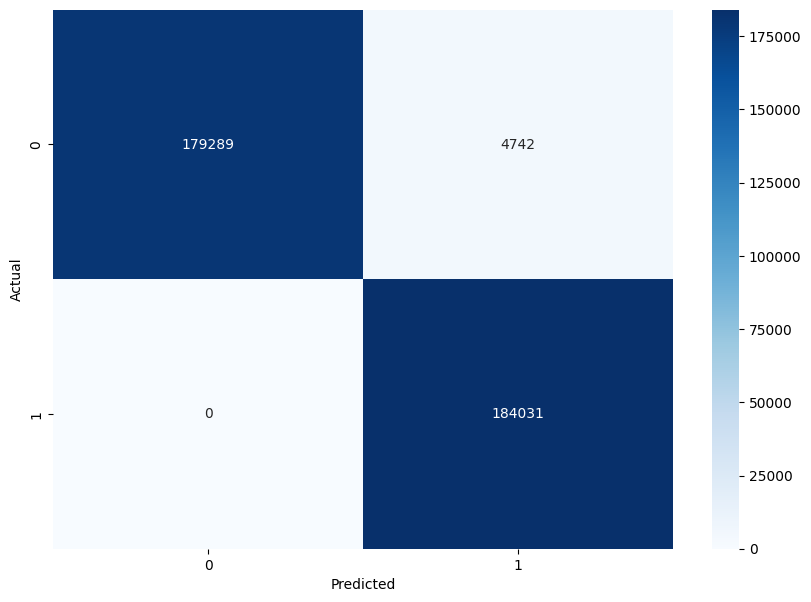

Accuracy:  0.9871163010579739


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
testing_data = pd.read_csv('../../Preprocess/GadgetX-NewMDCLUSTER-2/progenitor-pair/testing_data.csv')
testing_data = testing_data[features + progenitor_features]
X_new = testing_data.drop('Is_Progenitor', axis=1)
y_new = testing_data['Is_Progenitor']
X_new_scaled = scaler.transform(X_new)
y_new_pred_prob = model.predict(X_new_scaled)
y_new_pred = (y_new_pred_prob > 0.5).astype(int).flatten()
print(classification_report(y_new, y_new_pred))
cm = confusion_matrix(y_new, y_new_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
accuracy = accuracy_score(y_new, y_new_pred)
print('Accuracy: ', accuracy)


In [17]:
model.save('models/nn-128', overwrite=True, save_format="h5")

In [6]:
from keras.models import load_model
model = load_model('models/nn-128')

---

# Merger Trees

In [11]:
halo = new_data[new_data['ID'] == 36000000000001].iloc[-1] 
halo_id = 36000000000001
snapshot = 36
predicted_halo_history = track_halo_history_predicted(halo, model, scaler, new_data)
real_halo_history = track_halo_history_real(halo_id, snapshot, new_data)
plot_halo_history(halo['ID'], real_halo_history, predicted_halo_history, 'Halo Merger History - Redshift and Mass in 10^11 Solar Masses')
plot_real_and_predicted_history(halo_id, real_halo_history, predicted_halo_history)

MemoryError: 

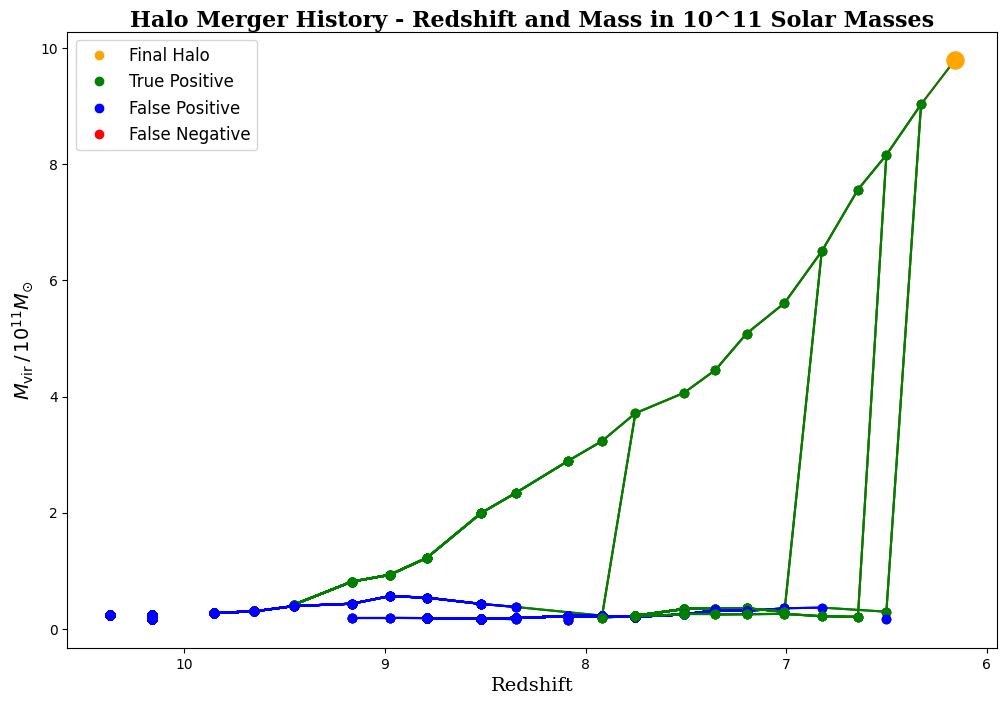

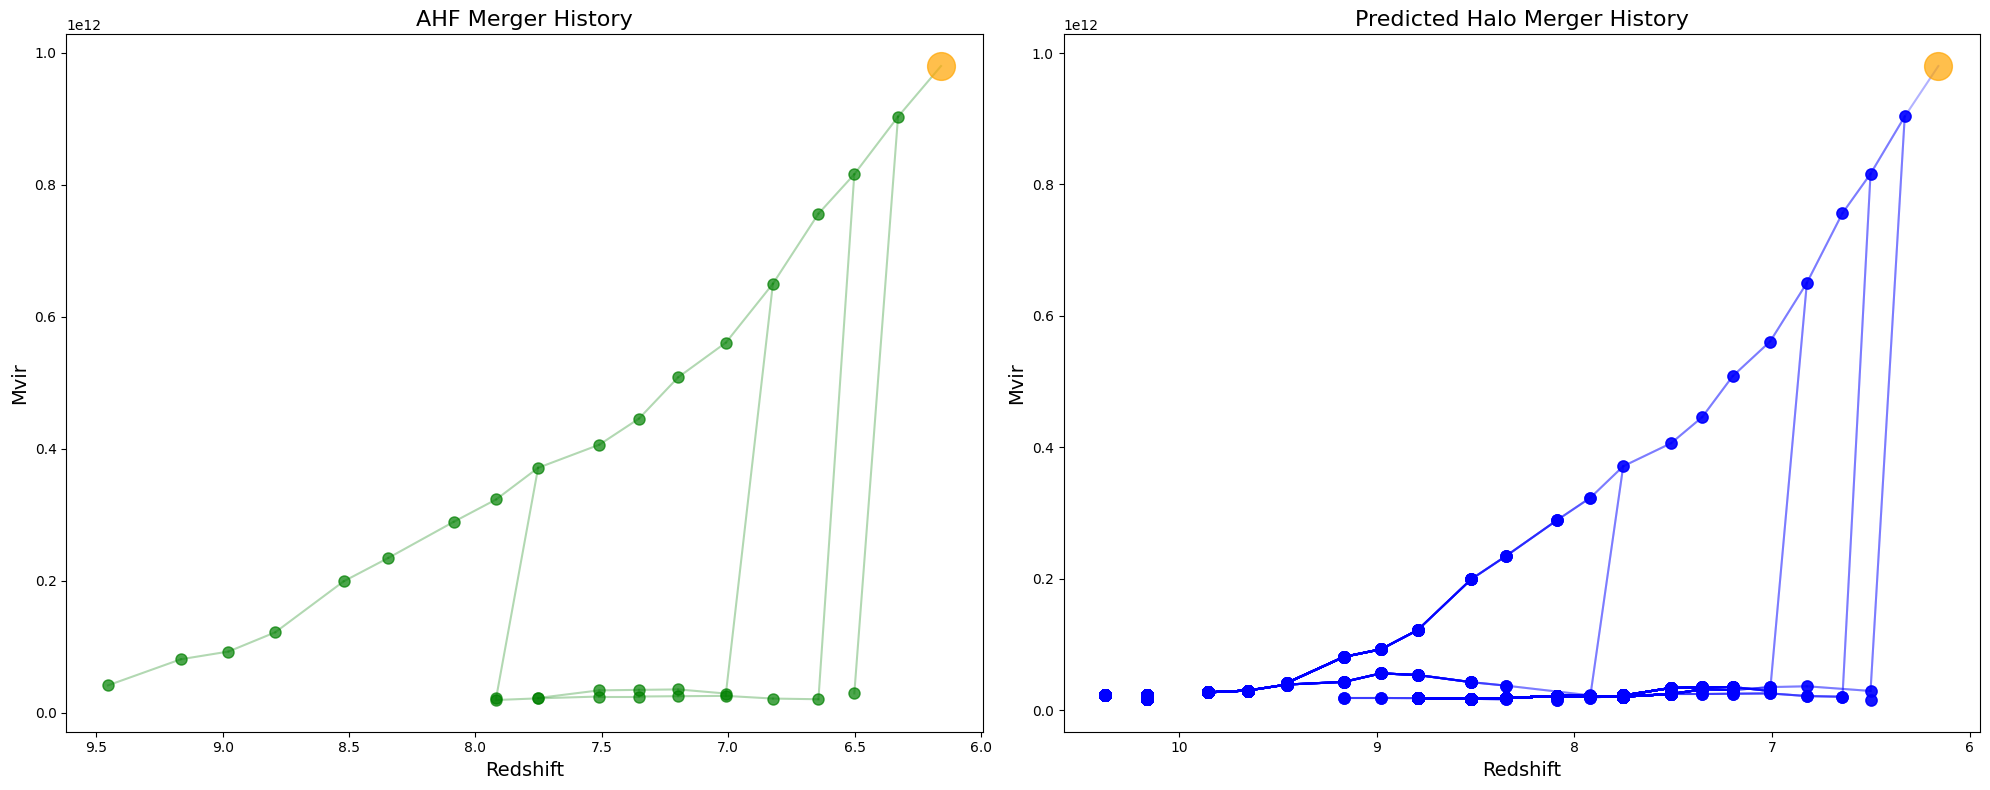

In [ ]:
halo = new_data[new_data['ID'] == 39000000000001].iloc[-1] 
halo_id = 39000000000001
snapshot = 39
predicted_halo_history = track_halo_history_predicted(halo, model, scaler, new_data)
real_halo_history = track_halo_history_real(halo_id, snapshot, new_data)
plot_halo_history(halo['ID'], real_halo_history, predicted_halo_history, 'Halo Merger History - Redshift and Mass in 10^11 Solar Masses')
plot_real_and_predicted_history(halo_id, real_halo_history, predicted_halo_history)

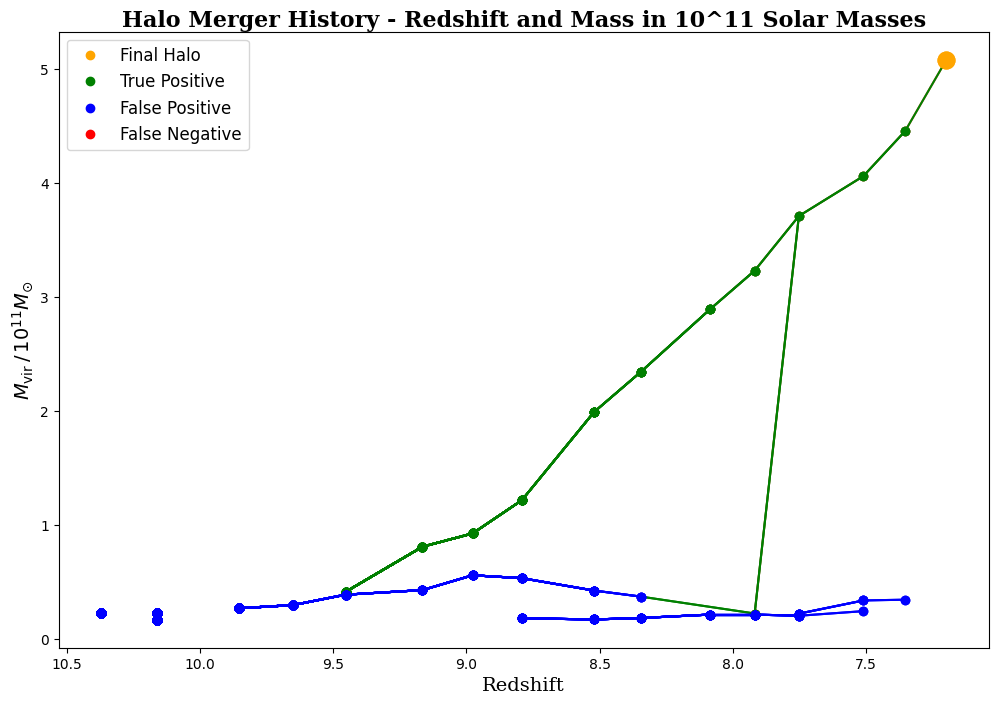

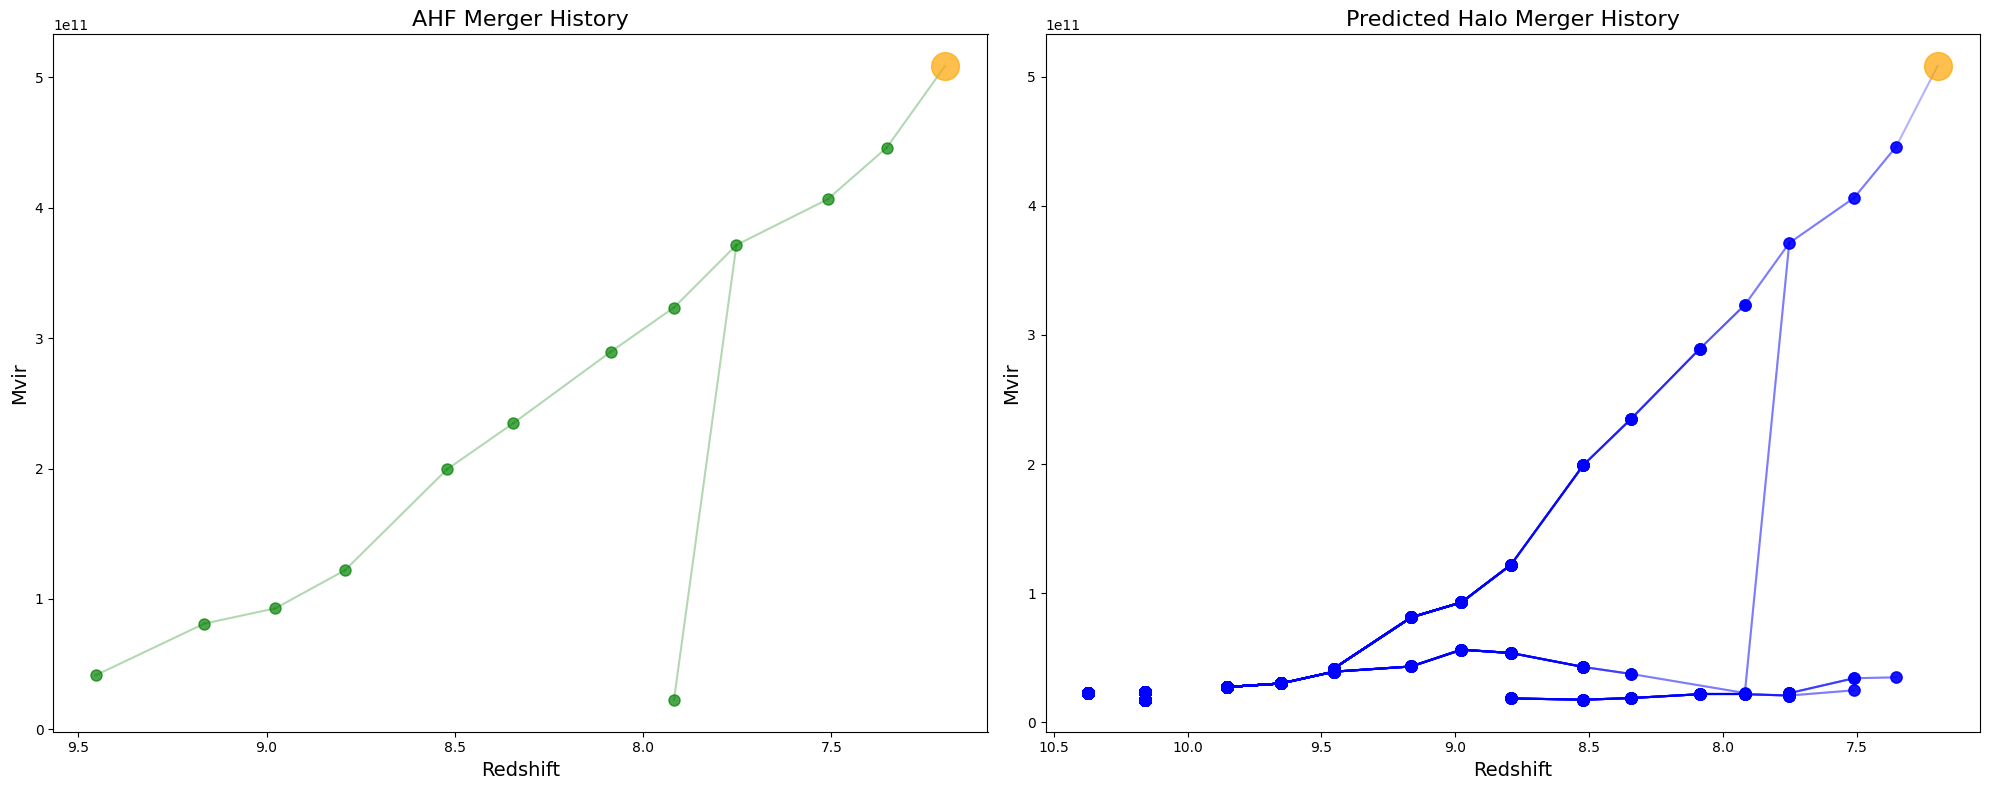

In [ ]:
halo = new_data[new_data['ID'] == 33000000000001].iloc[-1] 
halo_id = 33000000000001
snapshot = 33
predicted_halo_history = track_halo_history_predicted(halo, model, scaler, new_data)
real_halo_history = track_halo_history_real(halo_id, snapshot, new_data)
plot_halo_history(halo['ID'], real_halo_history, predicted_halo_history, 'Halo Merger History - Redshift and Mass in 10^11 Solar Masses')
plot_real_and_predicted_history(halo_id, real_halo_history, predicted_halo_history)

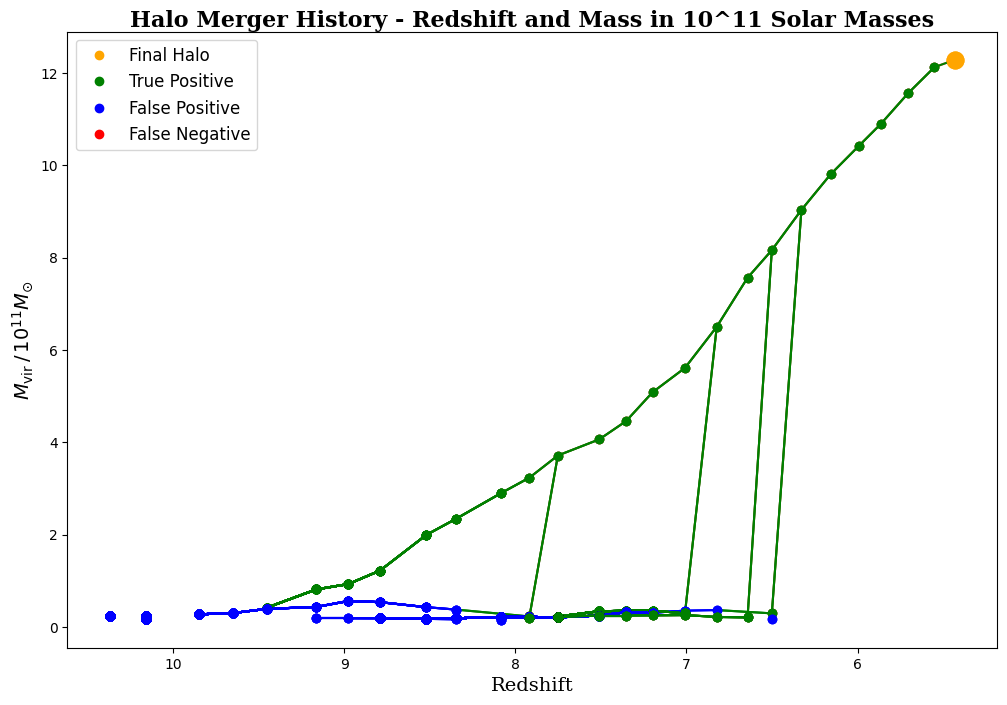

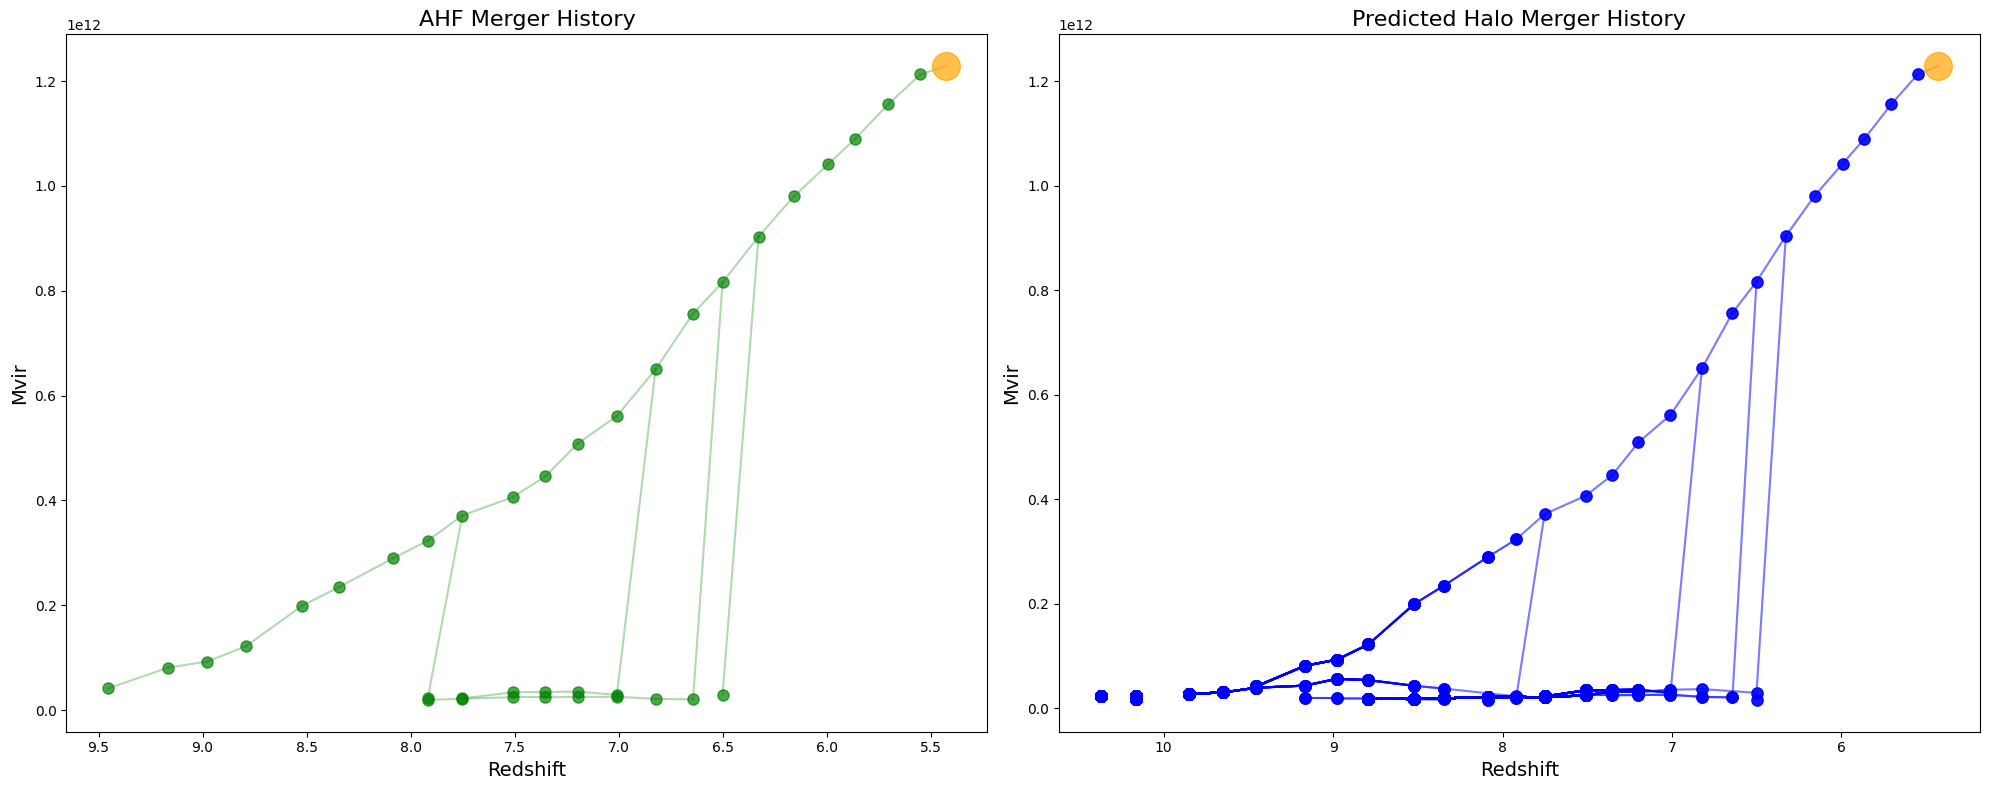

In [ ]:
halo = new_data[new_data['ID'] == 44000000000001].iloc[-1] 
halo_id = 44000000000001
snapshot = 44
predicted_halo_history = track_halo_history_predicted(halo, model, scaler, new_data)
real_halo_history = track_halo_history_real(halo_id, snapshot, new_data)
plot_halo_history(halo['ID'], real_halo_history, predicted_halo_history, 'Halo Merger History - Redshift and Mass in 10^11 Solar Masses')
plot_real_and_predicted_history(halo_id, real_halo_history, predicted_halo_history)